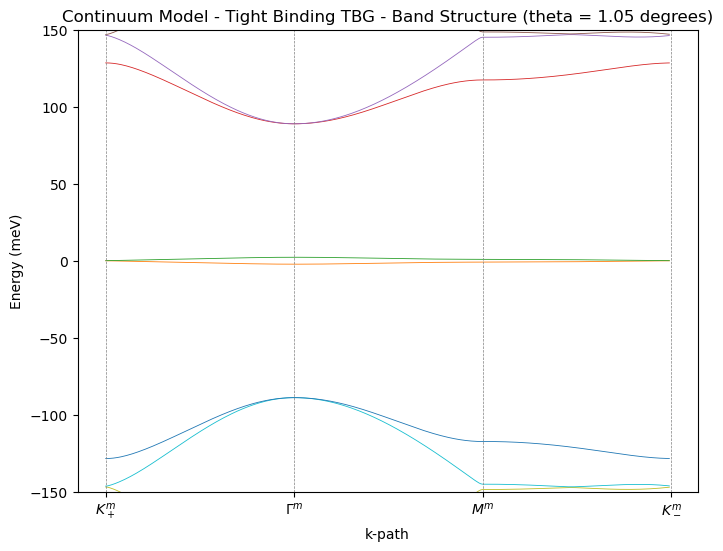

In [1]:
import numpy as np
import matplotlib.pyplot as plt

"""STEP 1: Define Parameters"""
theta = 1.05   #Twist Angle
theta = np.radians(theta)


w_ab = 97.5  # AB Tunneling Amplitudes
ratio = 0.0
w_aa = ratio * w_ab  # New w_aa based on ratio
d = 1.42 # C-C Distance
a = np.sqrt(3)*d  # lattice constant
hv = 2135.4 * a  # Fermi Velocity + Plank's Constant meV*angstrom
delk = 8 * np.pi * np.sin(theta / 2) / (a * 3)  # Moire Modulated reciprocal spacing constant for the mBZ
bm = 8 * np.pi * np.sin(theta / 2) / (a * 3)
valley = 1  # valley index

npts = 100
N = 4  # truncate range of Q mbz grid about k points

I = complex(0, 1)
ei120 = np.cos(2 * np.pi / 3) + valley * I * np.sin(2 * np.pi / 3)
ei240 = np.cos(2 * np.pi / 3) - valley * I * np.sin(2 * np.pi / 3)

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Define Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w_aa, w_ab, c3_angle):
    return w_aa * sigma_0 + w_ab * (np.cos(c3_angle) * sigma_x + np.sin(c3_angle) * sigma_y)

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def klines(A, B, numpts):
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

# Function to create the special k-path for TBG
def moire_kline(npts, delk):
    # Define the Moiré Brillouin zone endpoints
    Km_plus = delk * np.array([np.sqrt(3)/2, -1/2])
    Gamma_m = delk * np.array([0, 0])
    M_m = delk * np.array([np.sqrt(3)/2, 0])
    Km_minus = delk * np.array([np.sqrt(3)/2, 1/2])
    
    # Generate the k-path segments
    kline1 = klines(Km_plus, Gamma_m, npts)
    kline2 = klines(Gamma_m, M_m, npts)
    kline3 = klines(M_m, Km_minus, npts)
    
    # Labels for each segment
    klabels = [r'$K_+^m$', r'$\Gamma^m$', r'$M^m$', r'$K_-^m$']
    kcoord = np.array([0, (npts - 1), 2 * (npts - 1), 3 * (npts - 1)])
    
    # Concatenate the path segments
    return np.concatenate((kline1[:-1, :], kline2[:-1, :], kline3[:-1, :])), kcoord, klabels

# Calculate reciprocal lattice vectors
reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
b1, b2 = reciprocal_vectors

# Apply rotation to calculate the rotated reciprocal lattice vectors
b1_rot = np.dot(rotation_matrix(theta), b1)
b2_rot = np.dot(rotation_matrix(theta), b2)

# Calculate mBZ vectors G1m and G2m 
G1m = b1 - b1_rot  # Replacement for G1
G2m = b2 - b2_rot  # Replacement for G2

# mBZ K-point values These are points across the Mbz where we want adjacent points, we can just 3 fold rotate one k2 point to an equivalent point in the
#mbz to access this point
K1m = (1/3) * G1m + (2/3) * G2m
K2m = -(1/3) * G1m - (2/3) * G2m
K2m = np.dot(rotation_matrix(-2 * np.pi / 3), K2m) 
# This may require adjustment depending on parameters it is best to print out/plot the results to see if the align with expected values I computed just from the explicit geometry


""" K points in mBz from geometry
print(K1,K2)
# K-point values
K1 = 8 * np.pi * np.sin(theta / 2) / (a * 3) * array([sqrt(3) / 2, -0.5])
K2 = 8 * np.pi * np.sin(theta / 2) / (a * 3) * array([sqrt(3) / 2, 0.5])
print("New Line")
print(K1,K2)"""

# Momentum Changes Associated with the 3 distinct hopping processes
q1 = K2m - K1m
q2 = np.dot(rotation_matrix(2 * np.pi / 3), q1)
q3 = np.dot(rotation_matrix(4 * np.pi / 3), q1)

# Tunneling matrices
T1 = tunneling_matrix(w_aa, w_ab, 0)
T2 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3)
T3 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3)

siteN = (2 * N + 1) ** 2  # Replacement for waven
k = 0
L = np.array(np.zeros((siteN, 2)))

# Moiré BZ grid about K points
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

def Hamiltonian(kx, ky):
    # Initialize Hamiltonian
    H = np.zeros((4 * siteN, 4 * siteN), dtype=complex)

    # Loop through each lattice position to calculate q1, q2 and assign to Hamiltonian
    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        
        # Compute q1 and q2 as arrays with x and y components
        q1 = np.array([kx, ky]) - K1m + n1 * G1m + n2 * G2m
        q2 = np.array([kx, ky]) - K2m + n1 * G1m + n2 * G2m

        # Assign intralayer terms for each layer
        H[2*i:2*i+2, 2*i:2*i+2] = -hv * (valley * q1[0] * sigma_x + q1[1] * sigma_y)
        H[2*i+2*siteN:2*i+2*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = -hv * (valley * q2[0] * sigma_x + q2[1] * sigma_y)

        # Loop over other sites for interlayer coupling
        for j in range(siteN):
            m1 = L[j, 0]
            m2 = L[j, 1]

            # Set Kronecker delta values based on index shifts
            kd_0 = int((m1 == n1) and (m2 == n2))  # Checks if delta_q = q1
            kd_G1 = int((m1 == n1 - valley) and (m2 == n2))  # Checks if delta_q = q2
            kd_G1G2 = int((m1 == n1 - valley) and (m2 == n2 - valley))  # Checks if delta_q = q3

            # Combine tunneling matrices based on Kronecker delta values
            T = kd_0 * T1 + kd_G1 * T2 + kd_G1G2 * T3

            # Block assign the tunneling matrix T to the Hamiltonian
            H[2*i:2*i+2, 2*j+2*siteN:2*j+2*siteN+2] = T.conjugate().T
            H[2*j+2*siteN:2*j+2*siteN+2, 2*i:2*i+2] = T
    
    # Calculate and return sorted eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh for Hermitian matrix eigenvalues
    return np.sort(eigenvalues)

def plot_band_structure(Hamiltonian, npts, delk, theta_deg):
    k_path, kcoord, klabels = moire_kline(npts, delk)
    num_bands = 4 * siteN  # Adjust based on Hamiltonian size for TBG
    E = np.zeros((len(k_path), num_bands))
    
    # Evaluate Hamiltonian eigenvalues at each k-point along the path
    for idx, k_point in enumerate(k_path):
        kx, ky = k_point  # Extract kx and ky from the path point
        E[idx, :] = Hamiltonian(kx, ky)  # Directly store sorted eigenvalues

    # Plotting the band structure
    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(E[:, i], lw=0.6)
   
    # Customize plot
    plt.xticks(kcoord, klabels)  # Set tick positions and labels
    plt.xlabel("k-path")
    plt.ylabel("Energy (meV)")
    for xc in kcoord:
        plt.axvline(x=xc, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Continuum Model - Tight Binding TBG - Band Structure (theta = {theta_deg * 180/np.pi} degrees)")
    plt.ylim(-150, 150)
    plt.show()

plot_band_structure(Hamiltonian, npts, delk, theta)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

""" PARAMETERS """
# Parameters
n_layers = 3
theta = 1.5   # Twist Angle
theta = np.radians(theta)
theta_values = [theta, 0.0, -theta]

d = 1.42  # C-C Distance
a = np.sqrt(3) * d  # lattice constant
hv = 2135.4 * a  # Fermi Velocity + Planck's Constant meV*angstrom

delk = 8 * np.pi * np.sin(theta / 2) / (a * 3)  # Moire Modulated reciprocal spacing constant for the mBZ
bm = 8 * np.pi * np.sin(theta / 2) / (a * 3)
valley = 1  # valley index

N = 4  # truncate range of Q mbz grid about k points

w_ab = 110  # AB Tunneling Amplitudes
ratio = 0.0
w_aa = ratio * w_ab  # New w_aa based on ratio

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])


# Call the function to print the vectors
plot_geometry()
